<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Learnable_Fourier_Features_NN_for_Shock_Wave_DSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading all data variables...
Normalizing data...
Normalization successful.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features    │ (None, 128)       │         64 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,373 (196.77 KB)

 Trainable params: 50,373 (196.77 KB)

 Non-trainable params: 0 (0.00 B)


Starting training with learnable Fourier features...
Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1702 - val_loss: 0.1553
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1011 - val_loss: 0.0962
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0540 - val_loss: 0.0609
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - val_loss: 0.0473
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - val_loss: 0.0404
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0368
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0328
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - val_loss: 0.0296
Epoch 9/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0243
Epoch 10/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0202
Epoch 11/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - val_loss: 0.01

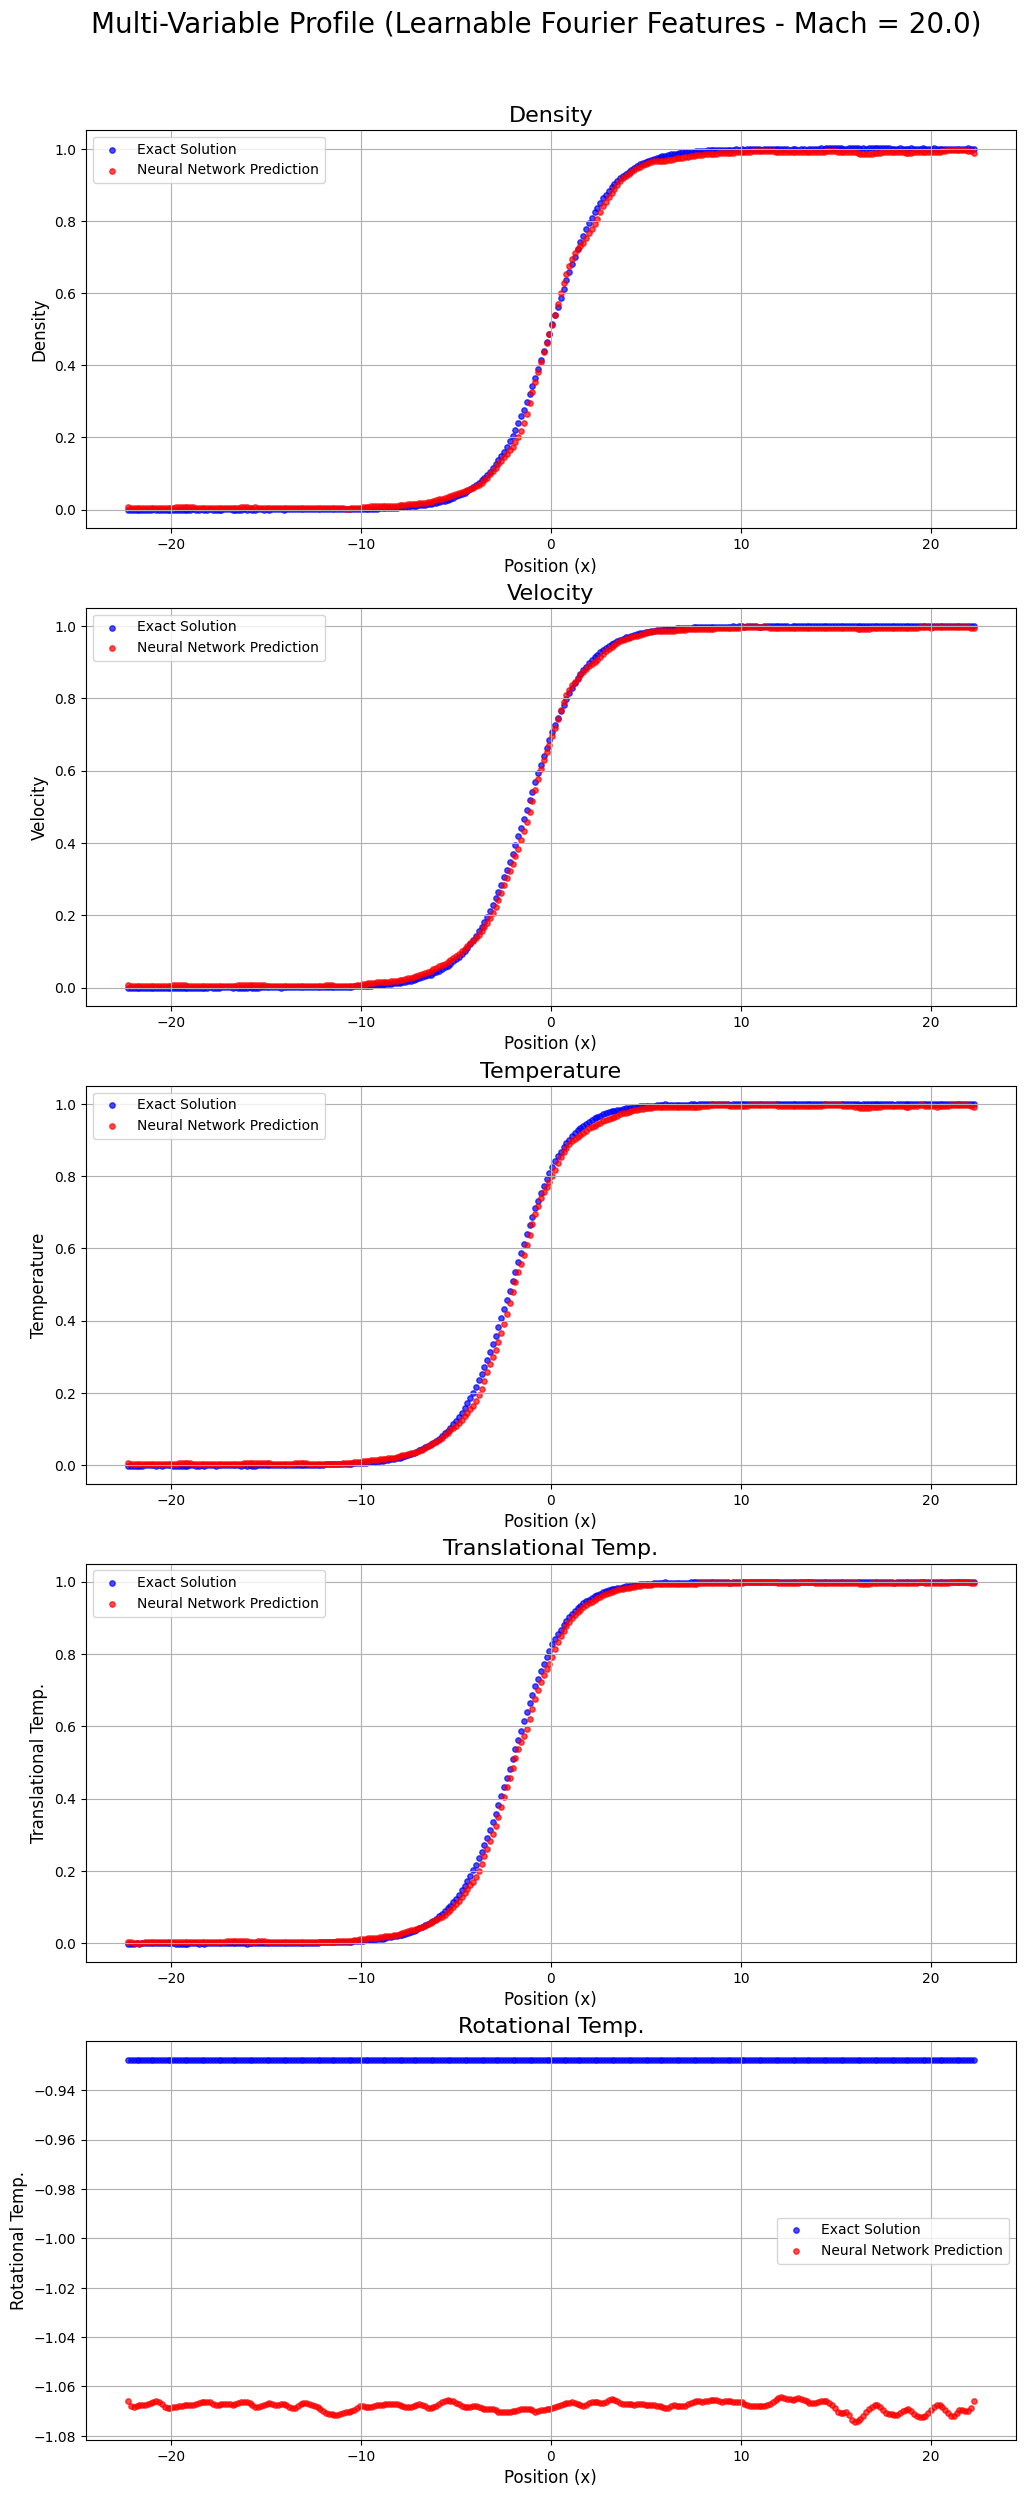

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

# --- 1. Learnable Fourier Feature Layer (Innovation) ---
# به جای کلاس قبلی، یک لایه سفارشی کراس می‌سازیم
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B را به عنوان یک وزن قابل آموزش تعریف می‌کنیم
        # توجه: ما فقط برای ورودی موقعیت (1 بعد) ویژگی فوریه می‌سازیم
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        # x ورودی موقعیت است
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading (No Changes) ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
test_file = 'M20.txt'
# (کد بارگذاری داده‌ها بدون تغییر باقی می‌ماند)
def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)
print("Loading all data variables...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_test, y_test, mach_test = load_data([test_file], DATASET_PATH)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)
mach_test = mach_test.reshape(-1, 1)

# --- 3. Normalization (Applied before feature mapping) ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# نرمال‌سازی داده‌های ورودی و خروجی
x_train_scaled = pos_scaler.fit_transform(x_train)
x_test_scaled = pos_scaler.transform(x_test)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
mach_test_scaled = mach_scaler.transform(mach_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("Normalization successful.")

# --- 4. Model Building with Learnable Fourier Features ---
# از مدل فانکشنال کراس برای ترکیب ورودی‌ها استفاده می‌کنیم
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# لایه ویژگی فوریه را روی ورودی موقعیت اعمال می‌کنیم
fourier_layer = FourierFeatures(output_dims=128)(pos_input)

# خروجی لایه فوریه را با ورودی عدد ماخ ترکیب می‌کنیم
concatenated_input = layers.concatenate([fourier_layer, mach_input])

# لایه‌های پنهان شبکه
x = layers.Dense(128, activation='tanh')(concatenated_input)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
output = layers.Dense(5, activation='sigmoid')(x)

# ساخت مدل نهایی
model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
# ورودی مدل حالا یک دیکشنری است
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with learnable Fourier features...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=1000,
    validation_split=0.2,
    verbose=1,
    batch_size=64 # استفاده از batch size می‌تواند به پایداری آموزش کمک کند
)
print("Training finished.")

# --- 6. Evaluation and Plotting ---
print("\nEvaluating and predicting...")
test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
loss = model.evaluate(test_inputs, y_test_scaled, verbose=0)
print(f"Mean Squared Error on Test Data (normalized): {loss:.6f}")

y_pred_scaled = model.predict(test_inputs)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

print("Plotting results...")
test_mach_number = mach_test[0, 0]
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

fig, axes = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle(f'Multi-Variable Profile (Learnable Fourier Features - Mach = {test_mach_number})', fontsize=20, y=0.92)

for i in range(5):
    ax = axes[i]
    ax.scatter(x_test, y_test[:, i], label='Exact Solution', color='blue', s=15, alpha=0.7)
    ax.scatter(x_test, y_pred[:, i], label='Neural Network Prediction', color='red', s=15, alpha=0.7)
    ax.set_title(output_labels[i], fontsize=16)
    ax.set_xlabel('Position (x)', fontsize=12)
    ax.set_ylabel(output_labels[i], fontsize=12)
    ax.legend()
    ax.grid(True)
plt.show()